## 1D PIC (evolution_version_relativistic) Landau Damping

Here we compute the 1D version of PIC. 
The initial distribution we use corresponds to a particles in a thermal bath with a given temperature and a spatial distribution given by a cosine function over a background.
The distribution is:

$$
f(x,v) = \frac{N}{L} \frac{1}{\sqrt{2\pi\theta}} e^{\frac{1 - \sqrt{1 + p^2}}{\theta}}(1 + \alpha cos(kx))
$$

We shall use $\theta = 0.001$, $\alpha = 0.01$ (some with $\alpha = 0.1$ for fun).

The normalization factors are not important because we then normalize the momentums of the distribution.

In [21]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell

nthreads = 10


Helper functions are defined in this file.

In [2]:
include("aux_functions.jl")

retrieve_meta_data (generic function with 1 method)

In [3]:

undamped = false
damped = false
vlasov_exp_200 = false
vlasov_exp_40 = false
#undamped = true
#damped = true
vlasov_exp_40 = true

true

In [38]:
run_name = "ltd_"
data_name = "par_dis_landau_rel_"
if undamped
    const L = 39.738 
    const J = 3522
    nm = 2 # this is defined again in inidat lambda = L/nm = 19.869
    data_name = data_name * "undamped_$(m)_"
    run_name = run_name * "undamped_rel_"
elseif damped
    const L = 7.455
    const J = 930
    nm = 15 # this is defined again in inidat lambda = L/nm = 0.497
    data_name = data_name * "damped_$(nm)_"
    run_name = run_name * "damped_rel_"
elseif vlasov_exp_200
    const L = 200
    const J = 2000
    const nm = 2 # this is defined again in inidat lambda = L/nm = 100
    data_name = data_name * "vla_200_$(nm)_"
    run_name = run_name * "vla_200rel_"
elseif vlasov_exp_40
    const L = 40
    const J = 400
    const nm = 2 # this is defined again in inidat lambda = L/nm = 20
    data_name = data_name * "vla_40_$(nm)_"
    run_name = run_name * "vla_40_rel_"
end
order = 5
alpha_exp = 3
α = 10.0^(-alpha_exp) # 0.1 0.001
θ = 0.001 # 0.001

N_exp = 5
N = 8*10^(N_exp)
exp_Theta = 3
θ = 10.0^(-exp_Theta)

@show data_name = data_name * "alp$(alpha_exp)_8$(N_exp)_Th$(exp_Theta)"

exp_t = 2
t = 0.0
t_i = 0.0
t_f = 10.0^(exp_t)
M = 2001 # 81 # 2001 # time steps 
M_g = 2000 + 1 #number of outputs, starting from the initial data
exp_alpha = 3
α = 10.0^(-exp_alpha)

κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
#p = (L, N, J, κ, dx, order)
dt = (t_f-t_i) / (M-1)
@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, L, J, dx, order)
@show pars_f = (θ, nm, κ)
par_init = (α, 2π*nm/L)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")

run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N8$(N_exp)_J$(J)_M$(M)_o$(order)_Th$(exp_Theta)_alp$(exp_alpha)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

data_name = data_name * "alp$(alpha_exp)_8$(N_exp)_Th$(exp_Theta)" = "par_dis_landau_rel_vla_40_2_alp3_85_Th3"
par_evolv = (t_i, t_f, M, M_g, dt) = (0.0, 100.0, 2001, 2001, 0.05)
par_grid = (N, L, J, dx, order) = (800000, 40, 400, 0.1, 5)
pars_f = (θ, nm, κ) = (0.001, 2, 0.15707963267948966)
t_f = 100.0, M = 2001, dt = 0.05, exp_Theta = 3
ltd_vla_40_rel_t100_L40_N85_J400_M2001_o5_Th3_alp3


In [26]:
outputs = false # detailed output (no longer used)
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.

false

We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 20000 * 5 / 2500 = 400$ ????

I think that actually we set the density to one, so that $\frac{N_e}{L} = 1$ irrespective on how many particles we take. 
That way $\theta_D = \lambda_D^2$



## Code parameters:

$\hat{k} = \frac{k}{\sqrt{\theta}}$

### Undamped
Thus, for $L = 39.738$, $J = 3522$, $\theta = 0.001$, $m = 2$ (second mode)

we have: $dx = 0.01128$, $k=\frac{4\pi}{L} = 0.3162305 $, $\hat{k} = 4*π /  39.738  * \sqrt{0.001} = 0.010000$

For this case the frequency should be: $\omega = 1.00015$


### Damped
Thus, for $L= 7.455$, $J = 930$, $\theta = 0.001$, $m = 15$

we have: $dx = 0.008$, $k=\frac{15*2\pi}{L} = 12.642 $, $\hat{k} = k  * \sqrt{0.001} = 0.399$

For this case the frequency should be: $\omega = 1.2855 - i 0.06613$


In [6]:
0.497 / 62
7.455 / 930
#15*0.497/930
15 * 2 * π / 7.455 #* sqrt(0.001)

3*0.399^2/2

0.2388015

We build the initial data:

In [7]:
E_i = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E

In [37]:
load("Initial_Distributions/" * data_name * ".jld2")

length(par_dis["par_dis"])
@assert length(par_dis["par_dis"]) ÷ 2 == N

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [9]:
get_density!(par_dis["par_dis"], n, par_grid)
get_ϕ!(ϕ, n .- 1., κ)
get_E_from_ϕ!(ϕ,E_i,dx)
u = [par_dis["par_dis"];E_i];
length(u)

1600400

### What follows are characterizations of the initial data properties.

In [10]:
get_current!(u, S, par_grid)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- 1.0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E_i))")

println("S_total = $(sum(S))")

39.9999787982992
4.3611691452838386e-5
n_total = -4.374278717023117e-14
v_total = 0.0
E_total = -1.3877787807814457e-17
S_total = -2.4913127116832356e-12


Compute the initial density, potential and electric field.

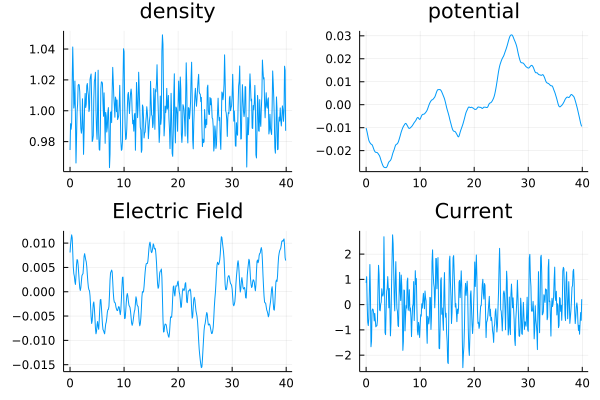

In [11]:
if !remote_server 
    plt = plot(layout=(2,2))
    plot!(subplot=1,x,n, title = "density", legend = :false)
    plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
    plot!(subplot=3,x,E_i, title = "Electric Field", legend = :false)
    
    plot!(subplot=4,x,S, title = "Current", legend = :false)
end

Check the histograms for the initial positions and velocities.

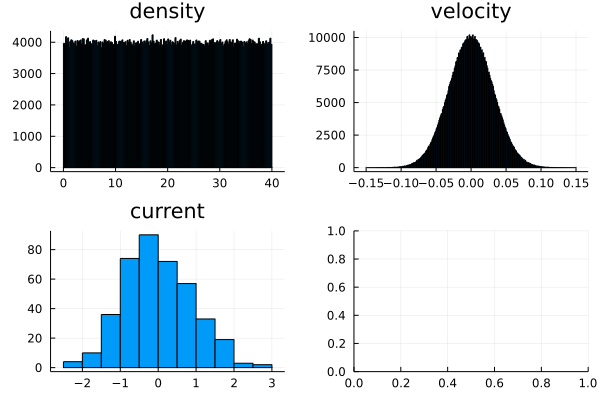

In [12]:
if !remote_server
    plot(layout=(2,2))
    histogram!(subplot=1,u[1:N], title = "density", legend = :false, bins = 300)
    histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

    histogram!(subplot=3,S, title = "current", legend = :false)
end

In [13]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
png(run_name * "initial-phase-space")
end

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [14]:
if nthreads() > 1
TS = zeros(J, nthreads())
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel_threads!, Interpolate_2, TS) ;
else
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel!, Interpolate_2) ;
end

if outputs  
    Energy_K = zeros(M_g)
    Energy_E = zeros(M_g)
    E_T = zeros(M_g)
    v_T = zeros(M_g)
    D_T = zeros(M_g)
    S_T = zeros(M_g)
    T = zeros(M_g)
    if animation
    par = zeros(M_g,2N)
    end
    Energy_K[1], Energy_E[1]  = get_energy(u,(L, N, J))
    E_T[1] = sum(u[2N+1:end])
    v_T[1] = sum(u[N+1:2N])
    get_density!(u, n, par_grid)
    get_current!(u, S, par_grid)
    D_T[1] = sum(n)/J - 1
    S_T[1] = sum(S)/J
    T[1] = var(u[N+1:2N])
    if animation
    par[1,:] = u[1:2N]
    end
end





In [15]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)
if outputs
    run_data = Dict()
    run["Energy_E_$j"] = Energy_E[j]
    run["Energy_K_$j"] = Energy_K[j]
    run["E_f$j"] = u[2N+1:end]
    run["n_F$j"] = ρ
    run["S_F$j"] = S
    run["E_T$j"] = EField_T[j] 
    run["S_T$j"] = S_T[j]
    run["n_T$j"] = n_T[j]
end


file_name = "Results/"* run_name * ".jld2"
#rm(file_name)

tiempo = @sprintf("%05d", j)
field_name = "u"

save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

jldopen(file_name, "a+") do file
    file[field_name * "/u_$(tiempo)"] = u;
end


1600400-element Vector{Float64}:
 24.47366445947687
 20.87443105997111
 14.913893636542007
 30.457252135755112
 31.531983075938058
 10.260604638137679
 21.36831348669114
 21.18821239293103
 26.18595438400404
 23.862126562724633
 23.66711317449862
 15.770855604439141
 27.43693104246408
  ⋮
  0.008442086994988858
  0.008707030780072657
  0.008971504227099861
  0.009695787239344035
  0.010378205077306435
  0.010498017284723275
  0.010386408897989429
  0.01066850607111321
  0.010860843229797109
  0.009470228299380606
  0.007035790743614703
  0.006417922598386406

In [16]:

for k in 2:M
  RK4_Step!(RHSC_rel,u,t,dt,p_RHSC)
  global u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    #scatter(plt, u[1:N], u[N+1:2*N])
    if outputs
      Energy_K[j], Energy_E[j] = get_energy_rel(u,(L, N, J))
      E_T[j] = sum(u[2N+1:end])
      v_T[j] = sum(u[N+1:2N])
      get_density!(u, n, par_grid)
      get_current_rel!(u, S, par_grid)
      D_T[j] = sum(n)/J - 1
      S_T[j] = sum(S)/J
      T[j] = var(u[N+1:2N])
    end

    local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
        end

    Energy_K, Energy_E = get_energy_rel(u,(L, N, J))
    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $(Energy_K + Energy_E)")

    if animation
    par[j,:] = u[1:2N]
    end
  end
end

j = 2 , t = 0.05, k = 2, nthreads = 10, Energy = 412.4553215570231
j = 3 , t = 0.1, k = 3, nthreads = 10, Energy = 412.45473817495196
j = 4 , t = 0.15000000000000002, k = 4, nthreads = 10, Energy = 412.4538680557135
j = 5 , t = 0.2, k = 5, nthreads = 10, Energy = 412.4527188458567
j = 6 , t = 0.25, k = 6, nthreads = 10, Energy = 412.45130069567955
j = 7 , t = 0.3, k = 7, nthreads = 10, Energy = 412.4496261664399
j = 8 , t = 0.35, k = 8, nthreads = 10, Energy = 412.4477101136575
j = 9 , t = 0.39999999999999997, k = 9, nthreads = 10, Energy = 412.44556954859263
j = 10 , t = 0.44999999999999996, k = 10, nthreads = 10, Energy = 412.44322347796236
j = 11 , t = 0.49999999999999994, k = 11, nthreads = 10, Energy = 412.4406927247018
j = 12 , t = 0.5499999999999999, k = 12, nthreads = 10, Energy = 412.43799973076835
j = 13 , t = 0.6, k = 13, nthreads = 10, Energy = 412.4351683445112
j = 14 , t = 0.65, k = 14, nthreads = 10, Energy = 412.4322235948438
j = 15 , t = 0.7000000000000001, k = 15, nth

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

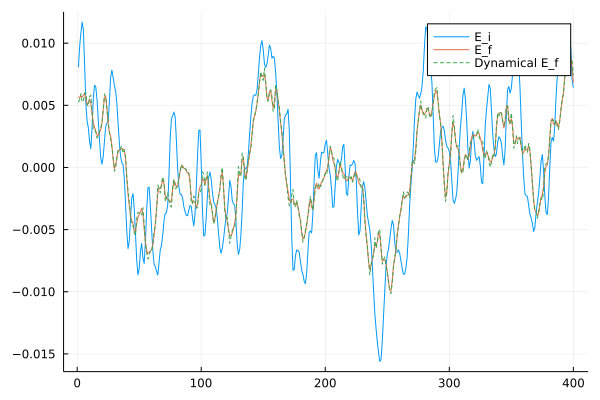

In [22]:
@bell sleep(3)
E_f = zeros(J)
#ϕ_f = zeros(J)
#n_f = zeros(J) #charge density
get_density!(u, n, par_grid)
get_ϕ!(ϕ, n .- 1.0, κ)
get_E_from_ϕ!(ϕ,E_f,dx)

plot(E_i, label="E_i")
plot!(E_f, label="E_f")
plot!(u[2N+1:end], ls=:dash, label="Dynamical E_f")

Saving the results

In [23]:
#=
n_F = zeros(J)
S_F = zeros(J)
get_density!(u, n_F, par_grid)
get_current!(u, S_F, par_grid)
run = Dict("run_name" => run_name, "p" => p, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[2N+1:end], "n_F" => n_F, "S_F" => S_F, "E_T"=> E_T, "v_T" => v_T, "S_T" => S_T, "D_T" => D_T, "T" => T)
save(run_name * "th$(nthreads())_results.jld2", run)
=#

In [ ]:
if remote_server
    exit() #if running as script
end

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

34 peaks in T = 100, so $\omega = 0.34$

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |
